In [1]:
import numpy as np
import cv2 as cv
import os
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop
from keras.applications.inception_v3 import preprocess_input
from matplotlib import gridspec

Using TensorFlow backend.


In [2]:
import timeit
start = timeit.default_timer()

In [3]:
# download the file from here >>> https://github.com/kohpangwei/influence-release/blob/master/inception/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
local_weights_file = 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [4]:
# include_top means that we loading model without last fully connected layers
pre_trained_model = InceptionV3(input_shape = (200, 200, 3), 
                                include_top = False, 
                                weights = None)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [5]:
# Loading InceptionV3 weights
pre_trained_model.load_weights(local_weights_file)

In [6]:
# lock training
for layer in pre_trained_model.layers:
    layer.trainable = False

In [7]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 99, 99, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 99, 99, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 99, 99, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [8]:
last_layer = pre_trained_model.get_layer('mixed10')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

In [9]:
# # Flatten the output layer to 1 dimension
# x = layers.Flatten()(last_output)
# # Add a fully connected layer with 1,024 hidden units and ReLU activation
# # x = layers.Dense(1024, activation='relu')(x)
# # x = layers.Dense(1024, activation='relu')(x)
# model = Model( pre_trained_model.input, x) 
# # model.compile(optimizer = RMSprop(lr=0.0001), loss = 'binary_crossentropy', metrics = ['acc'])

last layer output shape:  (None, 4, 4, 2048)


In [10]:
model = Model( pre_trained_model.input, last_output) 


I want to look how extracted features looks like, so I'll load one images and visualize it:


In [11]:
# Read image
orig = cv.imread('1.jpg')

# Convert image to RGB from BGR
orig = cv.cvtColor(orig, cv.COLOR_BGR2RGB)

In [12]:
# Resize image to 224x224 size
image = cv.resize(orig, (200, 200)).reshape(-1, 200, 200, 3)

In [13]:
print(image)

[[[[216 217 209]
   [216 215 210]
   [219 218 214]
   ...
   [227 226 224]
   [227 226 224]
   [227 226 224]]

  [[213 213 204]
   [217 216 211]
   [218 217 213]
   ...
   [227 226 224]
   [227 226 224]
   [227 226 224]]

  [[212 208 202]
   [220 217 212]
   [220 218 214]
   ...
   [227 226 224]
   [227 226 224]
   [227 226 224]]

  ...

  [[215 215 213]
   [216 216 214]
   [218 218 216]
   ...
   [227 227 225]
   [227 227 225]
   [227 227 225]]

  [[216 216 214]
   [217 217 215]
   [219 219 217]
   ...
   [226 226 224]
   [226 226 224]
   [226 226 224]]

  [[216 216 214]
   [217 217 215]
   [219 219 217]
   ...
   [226 226 224]
   [226 226 224]
   [226 226 224]]]]


In [14]:
# We need to preprocess imageto fulfill ResNet50 requirements
image = preprocess_input(image)

In [15]:
print(image)

[[[[0.69411767 0.7019608  0.6392157 ]
   [0.69411767 0.6862745  0.64705884]
   [0.7176471  0.70980394 0.6784314 ]
   ...
   [0.78039217 0.77254903 0.75686276]
   [0.78039217 0.77254903 0.75686276]
   [0.78039217 0.77254903 0.75686276]]

  [[0.67058825 0.67058825 0.6       ]
   [0.7019608  0.69411767 0.654902  ]
   [0.70980394 0.7019608  0.67058825]
   ...
   [0.78039217 0.77254903 0.75686276]
   [0.78039217 0.77254903 0.75686276]
   [0.78039217 0.77254903 0.75686276]]

  [[0.6627451  0.6313726  0.58431375]
   [0.7254902  0.7019608  0.6627451 ]
   [0.7254902  0.70980394 0.6784314 ]
   ...
   [0.78039217 0.77254903 0.75686276]
   [0.78039217 0.77254903 0.75686276]
   [0.78039217 0.77254903 0.75686276]]

  ...

  [[0.6862745  0.6862745  0.67058825]
   [0.69411767 0.69411767 0.6784314 ]
   [0.70980394 0.70980394 0.69411767]
   ...
   [0.78039217 0.78039217 0.7647059 ]
   [0.78039217 0.78039217 0.7647059 ]
   [0.78039217 0.78039217 0.7647059 ]]

  [[0.69411767 0.69411767 0.6784314 ]
   [0.7

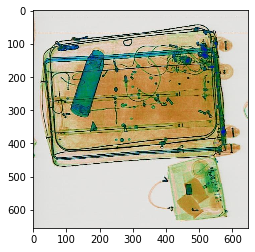

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


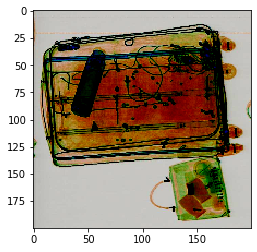

In [16]:
# plot original image and preprocessed image
plt.imshow(orig)
plt.show()
plt.imshow(image[0])
plt.show()

In [17]:
# Extracting our features
features = model.predict(image)

In [18]:
print(features.shape)

(1, 4, 4, 2048)


Now "features" array contains 2048 feature maps wits 4x4 size.

I want to plot random 9 features as example:

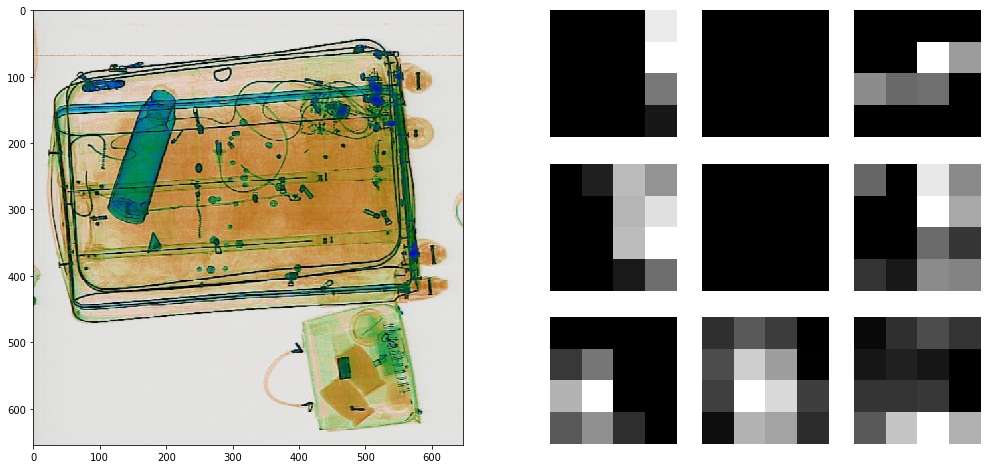

In [19]:
n_features = features.shape[-1]

fig = plt.figure(figsize = (17, 8))
gs = gridspec.GridSpec(1, 2, figure = fig)
sub_gs = gridspec.GridSpecFromSubplotSpec(3, 3, subplot_spec=gs[1])

ax1 = fig.add_subplot(gs[0])
ax1.imshow(orig)

for i in range(3):
    for j in range(3):
        ax2 = fig.add_subplot(sub_gs[i, j])
        plt.axis('off')        
        plt.imshow(features[0, :, :, np.random.randint(n_features)], cmap = 'gray') 

In [20]:
# history = model.fit_generator(
#             train_generator,
#             validation_data = validation_generator,
#             steps_per_epoch = 100,
#             epochs = 20,
#             validation_steps = 50,
#             verbose = 2)

In [21]:
path = 'dataset2'

# List of splts: ['P','N']
sets = os.listdir(path)

# Arrays to store data
X, Y = ([], [])

data = [X, Y]

print(data)

[[], []]


N cells:


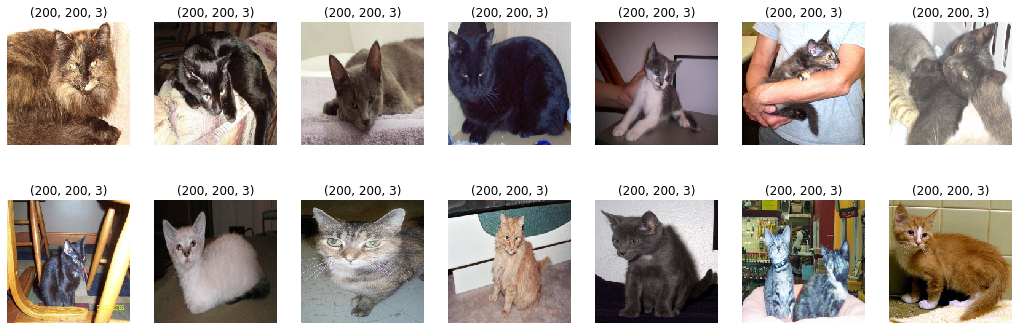

P cells:


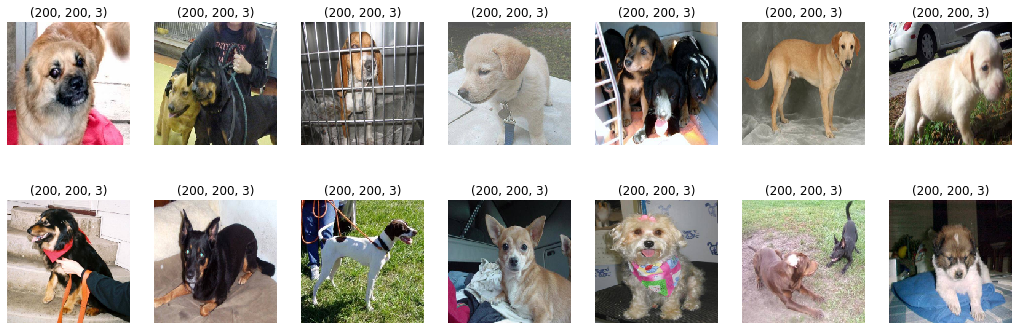

In [22]:
import random
# Plot random images of each class
IMG_SIZE = (200, 200)
N_DIMS = 3
rows, cols = (2, 7)

for c in sets:
    print(f'{c} cells:')
    path_to_folder = os.path.join(path, c)
    fig = plt.figure(figsize = (18, 6))
    
    for i in range(rows*cols):
        random_image = random.choice(os.listdir(path_to_folder))
        path_to_image = os.path.join(path_to_folder, random_image)        
        image = cv.imread(path_to_image)
        image = cv.resize(image, (IMG_SIZE[0], IMG_SIZE[1]))
        
        fig.add_subplot(rows, cols, i+1)
        plt.imshow(image[:, :, ::-1])
        plt.axis('off')
        plt.title(image.shape)
    plt.show()

In [23]:
# Loop through all splits

# Loop through categories in split
for category in sets:     # categories = N or P
    # Defining path to images in category
    path_to_images = os.path.join(path, category)

    # Defining labels
    if category == 'P':
        label = 1
    else:
        label = 0

    # Loop through images in category
    for i in os.listdir(path_to_images):
        # Path to image
        image_path = os.path.join(path_to_images, i)

        # Reading and preprocessing image
        image = cv.imread(image_path)
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        image = cv.resize(image, (200, 200)).reshape(-1, 200, 200, 3)
        image = preprocess_input(image)

        # Extracting features
        features = model.predict(image).reshape(32768)

        # Store features and label in our lists
        X.append(features)
        Y.append(label)


In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.1, random_state=2)

In [25]:
X_train = np.array(X_train)
X_test = np.array(X_test)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

In [26]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(256, input_shape = (32768,), activation = 'relu', kernel_initializer = 'he_normal'))
model.add(Dense(16, activation = 'relu', kernel_initializer = 'he_normal'))
model.add(Dense(1, activation = 'sigmoid'))

In [27]:
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('best_model.hdf5', monitor = 'val_accuracy', verbose = 1, save_best_only = True)
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.fit(X_train, Y_train, batch_size = 64, epochs = 30,callbacks = [checkpoint])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/30
20250/20250 [==============================] - 11s 531us/step - loss: 0.1524 - accuracy: 0.9716
Epoch 2/30
  320/20250 [..............................] - ETA: 8s - loss: 0.0529 - accuracy: 0.9875

D:\anaconda\lib\site-packages\keras\callbacks\callbacks.py:707: RuntimeWarning: Can save best model only with val_accuracy available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


20250/20250 [==============================] - 8s 385us/step - loss: 0.0622 - accuracy: 0.9819
Epoch 3/30
20250/20250 [==============================] - 8s 390us/step - loss: 0.0400 - accuracy: 0.9874
Epoch 4/30
20250/20250 [==============================] - 8s 382us/step - loss: 0.0307 - accuracy: 0.9883
Epoch 5/30
20250/20250 [==============================] - 8s 384us/step - loss: 0.0286 - accuracy: 0.9900
Epoch 6/30
20250/20250 [==============================] - 8s 382us/step - loss: 0.0260 - accuracy: 0.9909
Epoch 7/30
20250/20250 [==============================] - 8s 387us/step - loss: 0.0273 - accuracy: 0.9915
Epoch 8/30
20250/20250 [==============================] - 8s 382us/step - loss: 0.0205 - accuracy: 0.9939
Epoch 9/30
20250/20250 [==============================] - 8s 398us/step - loss: 0.0199 - accuracy: 0.9928
Epoch 10/30
20250/20250 [==============================] - 8s 383us/step - loss: 0.0256 - accuracy: 0.9922
Epoch 11/30
20250/20250 [==============================]

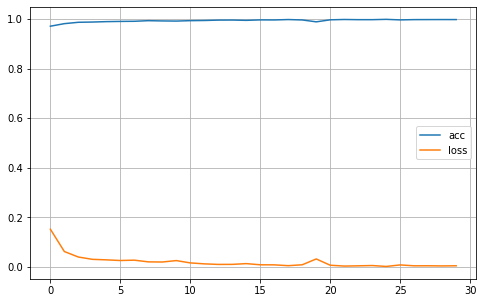

In [28]:
# Plot losses and accuracies
history = model.history.history

fig = plt.figure(figsize = (8, 5))
plt.plot(history['accuracy'], label = 'acc')
# plt.plot(history['val_accuracy'], label = 'val_acc')
plt.plot(history['loss'], label = 'loss')
# plt.plot(history['val_loss'], label = 'val_loss')
plt.grid()
plt.legend()
plt.show()

In [29]:
# Making predictions using evaluation dataset
preds = model.predict(X_test)
preds

array([[1.0000000e+00],
       [0.0000000e+00],
       [5.9604645e-08],
       ...,
       [5.9604645e-08],
       [1.7082118e-06],
       [9.9992800e-01]], dtype=float32)

In [30]:
preds = [1 if i > 0.5 else 0 for i in preds]
preds

[1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,


In [31]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Calculating accuracy score
accuracy = accuracy_score(Y_test, preds)
print(f'Accuracy: {round(accuracy * 100, 4)}%')

Accuracy: 98.6222%


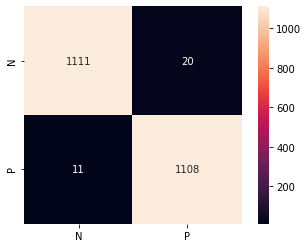

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

l = ['N', 'P']
confusion = confusion_matrix(Y_test, preds)
sns.heatmap(confusion, square = True, fmt = 'd', xticklabels = l, yticklabels = l, annot = True)

In [33]:
stop = timeit.default_timer()
print('Time: ', stop - start)

Time:  1069.3151539
